# VinBigData detectron2 prediction


**Following from the training kernel [VinBigData detectron2 train](https://www.kaggle.com/corochann/vinbigdata-detectron2-train), I will try prediction with the `detectron2` trained model**

`detectron2` is one of the famous pytorch object detection library, I will introduce how to use this library to predict bounding boxes with the trained model.

 - https://github.com/facebookresearch/detectron2

> Detectron2 is Facebook AI Research's next generation software system that implements state-of-the-art object detection algorithms. It is a ground-up rewrite of the previous version, Detectron, and it originates from maskrcnn-benchmark.
![](https://user-images.githubusercontent.com/1381301/66535560-d3422200-eace-11e9-9123-5535d469db19.png)


## Version history

2021/1/22: Update to add 2-class filter in troduced in [VinBigData 🌟2 Class Filter🌟](https://www.kaggle.com/awsaf49/vinbigdata-2-class-filter) by @awsaf49 <br/>
I also wrote kernel to train 2-class model: [📸VinBigData 2-class classifier complete pipeline](https://www.kaggle.com/corochann/vinbigdata-2-class-classifier-complete-pipeline)

2021/2/6: Updated trained model [vinbigdata-alb-aug-512-cos](https://www.kaggle.com/corochann/vinbigdata-alb-aug-512-cos).<br/>
Updated prediction kernel to align training kernel [VinBigData detectron2 train](https://www.kaggle.com/corochann/vinbigdata-detectron2-train), which uses customized augmentation.<br/>
Apply 2-class filter in [📸VinBigData 2-class classifier complete pipeline](https://www.kaggle.com/corochann/vinbigdata-2-class-classifier-complete-pipeline).

# Table of Contents

** [Prediction method implementations](#pred_method)** <br/>
** [Prediction scripts](#pred_scripts)** <br/>
** [Apply 2 class filter](#2class)** <br/>
** [Other kernels](#ref)** <br/>

Since first setup part is same with the training kernel, I skipped listing on ToC.

# Dataset preparation

Preprocessing x-ray image format (dicom) into normal png image format is already done by @xhlulu in the below discussion:
 - [Multiple preprocessed datasets: 256/512/1024px, PNG and JPG, modified and original ratio](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/207955).

Here I will just use the dataset [VinBigData Chest X-ray Resized PNG (256x256)](https://www.kaggle.com/xhlulu/vinbigdata-chest-xray-resized-png-256x256) to skip the preprocessing and focus on modeling part. Please upvote the dataset as well!

In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
# import scipy as sp


import matplotlib.pyplot as plt
# import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
# from sklearn import preprocessing
# from sklearn.model_selection import KFold
# import lightgbm as lgb
# import xgboost as xgb
# import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)


# Installation

detectron2 is not pre-installed in this kaggle docker, so let's install it. 
We can follow [installation instruction](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md), we need to know CUDA and pytorch version to install correct `detectron2`.

In [2]:
# !nvidia-smi

In [3]:
!nvcc --version

zsh:1: command not found: nvcc


In [4]:
import torch

torch.__version__

/home/xenwithu/Documents/VNPTIT/PythonProject/.venv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



'1.7.0'

It seems CUDA=10.2 and torch==1.7.0 is used in this kaggle docker image.

See [installation](https://detectron2.readthedocs.io/tutorials/install.html) for details.

In [5]:
# !pip install detectron2 -f \
#   https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html

<a id="pred_method"></a>
# Prediction method implementations

Basically we don't need to implement neural network part, `detectron2` already implements famous architectures and provides its pre-trained weights. We can finetune these pre-trained architectures.

These models are summarized in [MODEL_ZOO.md](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md).

In this competition, we need object detection model, I will choose [R50-FPN](https://github.com/facebookresearch/detectron2/blob/master/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml) for this kernel.

## Data preparation

`detectron2` provides high-level API for training custom dataset.

To define custom dataset, we need to create **list of dict** where each dict contains following:

 - file_name: file name of the image.
 - image_id: id of the image, index is used here.
 - height: height of the image.
 - width: width of the image.
 - annotation: This is the ground truth annotation data for object detection, which contains following
     - bbox: bounding box pixel location with shape (n_boxes, 4)
     - bbox_mode: `BoxMode.XYXY_ABS` is used here, meaning that absolute value of (xmin, ymin, xmax, ymax) annotation is used in the `bbox`.
     - category_id: class label id for each bounding box, with shape (n_boxes,)

`get_vinbigdata_dicts` is for train dataset preparation and `get_vinbigdata_dicts_test` is for test dataset preparation.

In [6]:
import pickle
from pathlib import Path
from typing import Optional

import cv2
import numpy as np
import pandas as pd
from detectron2.structures import BoxMode
from tqdm import tqdm


def get_vinbigdata_dicts(
    imgdir: Path,
    train_df: pd.DataFrame,
    train_data_type: str = "original",
    use_cache: bool = True,
    debug: bool = True,
    target_indices: Optional[np.ndarray] = None,
    use_class14: bool = False,
):
    debug_str = f"_debug{int(debug)}"
    train_data_type_str = f"_{train_data_type}"
    class14_str = f"_14class{int(use_class14)}"
    cache_path = Path(".") / f"dataset_dicts_cache{train_data_type_str}{class14_str}{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        train_meta = pd.read_csv(imgdir / "train_meta.csv")
        if debug:
            train_meta = train_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = train_meta.loc[0, "image_id"]
        image_path = str(imgdir / "train" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, train_meta_row in tqdm(train_meta.iterrows(), total=len(train_meta)):
            record = {}

            image_id, height, width = train_meta_row.values
            filename = str(imgdir / "train" / f"{image_id}.png")
            record["file_name"] = filename
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width
            objs = []
            for index2, row in train_df.query("image_id == @image_id").iterrows():
                # print(row)
                # print(row["class_name"])
                # class_name = row["class_name"]
                class_id = row["class_id"]
                if class_id == 14:
                    # It is "No finding"
                    if use_class14:
                        # Use this No finding class with the bbox covering all image area.
                        bbox_resized = [0, 0, resized_width, resized_height]
                        obj = {
                            "bbox": bbox_resized,
                            "bbox_mode": BoxMode.XYXY_ABS,
                            "category_id": class_id,
                        }
                        objs.append(obj)
                    else:
                        # This annotator does not find anything, skip.
                        pass
                else:
                    # bbox_original = [int(row["x_min"]), int(row["y_min"]), int(row["x_max"]), int(row["y_max"])]
                    h_ratio = resized_height / height
                    w_ratio = resized_width / width
                    bbox_resized = [
                        float(row["x_min"]) * w_ratio,
                        float(row["y_min"]) * h_ratio,
                        float(row["x_max"]) * w_ratio,
                        float(row["y_max"]) * h_ratio,
                    ]
                    obj = {
                        "bbox": bbox_resized,
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "category_id": class_id,
                    }
                    objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]
    return dataset_dicts


def get_vinbigdata_dicts_test(
    imgdir: Path, test_meta: pd.DataFrame, use_cache: bool = True, debug: bool = True,
):
    debug_str = f"_debug{int(debug)}"
    cache_path = Path(".") / f"dataset_dicts_cache_test{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        # test_meta = pd.read_csv(imgdir / "test_meta.csv")
        if debug:
            test_meta = test_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = test_meta.loc[0, "image_id"]
        image_path = str(imgdir / "test" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, test_meta_row in tqdm(test_meta.iterrows(), total=len(test_meta)):
            record = {}

            image_id, height, width = test_meta_row.values
            filename = str(imgdir / "test" / f"{image_id}.png")
            record["file_name"] = filename
            # record["image_id"] = index
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width
            # objs = []
            # record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    return dataset_dicts

Methods for prediction for this competition

In [7]:
# Methods for prediction for this competition
from math import ceil
from typing import Any, Dict, List

import cv2
import detectron2
import numpy as np
from numpy import ndarray
import pandas as pd
import torch
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import ColorMode, Visualizer
from tqdm import tqdm


def format_pred(labels: ndarray, boxes: ndarray, scores: ndarray) -> str:
    pred_strings = []
    for label, score, bbox in zip(labels, scores, boxes):
        xmin, ymin, xmax, ymax = bbox.astype(np.int64)
        pred_strings.append(f"{label} {score} {xmin} {ymin} {xmax} {ymax}")
    return " ".join(pred_strings)


def predict_batch(predictor: DefaultPredictor, im_list: List[ndarray]) -> List:
    with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
        inputs_list = []
        for original_image in im_list:
            # Apply pre-processing to image.
            if predictor.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            # Do not apply original augmentation, which is resize.
            # image = predictor.aug.get_transform(original_image).apply_image(original_image)
            image = original_image
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
            inputs = {"image": image, "height": height, "width": width}
            inputs_list.append(inputs)
        predictions = predictor.model(inputs_list)
        return predictions

In [8]:
# --- utils ---
from pathlib import Path
from typing import Any, Union

import yaml


def save_yaml(filepath: Union[str, Path], content: Any, width: int = 120):
    with open(filepath, "w") as f:
        yaml.dump(content, f, width=width)


def load_yaml(filepath: Union[str, Path]) -> Any:
    with open(filepath, "r") as f:
        content = yaml.full_load(f)
    return content


In [9]:
# --- configs ---
thing_classes = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis"
]
category_name_to_id = {class_name: index for index, class_name in enumerate(thing_classes)}


This `Flags` class is to manage experiments. I will tune these parameters through the competition to improve model's performance.

In [10]:
# --- flags ---
from dataclasses import dataclass, field
from typing import Dict


@dataclass
class Flags:
    # General
    debug: bool = True
    outdir: str = "results/det"

    # Data config
    imgdir_name: str = "vinbigdata-chest-xray-resized-png-256x256"
    split_mode: str = "all_train"  # all_train or valid20
    seed: int = 111
    train_data_type: str = "original"  # original or wbf
    use_class14: bool = False
    # Training config
    iter: int = 10000
    ims_per_batch: int = 2  # images per batch, this corresponds to "total batch size"
    num_workers: int = 4
    lr_scheduler_name: str = "WarmupMultiStepLR"  # WarmupMultiStepLR (default) or WarmupCosineLR
    base_lr: float = 0.00025
    roi_batch_size_per_image: int = 512
    eval_period: int = 10000
    aug_kwargs: Dict = field(default_factory=lambda: {})

    def update(self, param_dict: Dict) -> "Flags":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self

<a id="pred_scripts"></a>
# Prediction scripts

Now the methods are ready. Main training scripts starts from here.

In [11]:
inputdir = Path("./vinbigdata-alb-512-cos")
traineddir = inputdir / "model"
print('traineddir: ',traineddir)

# flags = Flags()
flags: Flags = Flags().update(load_yaml(str(traineddir/"flags.yaml")))
print("flags", flags)
debug = flags.debug
# flags_dict = dataclasses.asdict(flags)
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)

# --- Read data ---
datadir = inputdir / "vinbigdata-chest-xray-abnormalities-detection"
if flags.imgdir_name == "vinbigdata-chest-xray-resized-png-512x512":
    imgdir = inputdir/ "vinbigdata"
    print('size test 512')
else:
    imgdir = inputdir / flags.imgdir_name
    print('size test 256')

# Read in the data CSV files
# train = pd.read_csv(datadir / "train.csv")
test_meta = pd.read_csv(inputdir / "vinbigdata-testmeta" / "test_meta.csv")
sample_submission = pd.read_csv(datadir / "sample_submission.csv")

traineddir:  vinbigdata-alb-512-cos/vinbigdata-alb-aug-512-cos


FileNotFoundError: [Errno 2] No such file or directory: 'vinbigdata-alb-512-cos/vinbigdata-alb-aug-512-cos/flags.yaml'

In [ ]:
print(imgdir)

/kaggle/input/vinbigdata


In [ ]:
cfg = get_cfg()
original_output_dir = cfg.OUTPUT_DIR
cfg.OUTPUT_DIR = str(outdir)
print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("vinbigdata_train",)
cfg.DATASETS.TEST = ()
# cfg.DATASETS.TEST = ("vinbigdata_train",)
# cfg.TEST.EVAL_PERIOD = 50
cfg.DATALOADER.NUM_WORKERS = 2
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = flags.base_lr  # pick a good LR
cfg.SOLVER.MAX_ITER = flags.iter
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = flags.roi_batch_size_per_image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

### --- Inference & Evaluation ---
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
# path to the model we just trained
cfg.MODEL.WEIGHTS = str(traineddir/"model_final.pth")
print("Original thresh", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)  # 0.05
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6  # set a custom testing threshold
print("Changed  thresh", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)
predictor = DefaultPredictor(cfg)

DatasetCatalog.register(
    "vinbigdata_test", lambda: get_vinbigdata_dicts_test(imgdir, test_meta, debug=debug)
)
MetadataCatalog.get("vinbigdata_test").set(thing_classes=thing_classes)
metadata = MetadataCatalog.get("vinbigdata_test")
dataset_dicts = get_vinbigdata_dicts_test(imgdir, test_meta, debug=debug)

if debug:
    dataset_dicts = dataset_dicts[:100]

results_list = []
index = 0
batch_size = 4

for i in tqdm(range(ceil(len(dataset_dicts) / batch_size))):
    inds = list(range(batch_size * i, min(batch_size * (i + 1), len(dataset_dicts))))
    dataset_dicts_batch = [dataset_dicts[i] for i in inds]
    im_list = [cv2.imread(d["file_name"]) for d in dataset_dicts_batch]
    outputs_list = predict_batch(predictor, im_list)

    for im, outputs, d in zip(im_list, outputs_list, dataset_dicts_batch):
        resized_height, resized_width, ch = im.shape
        # outputs = predictor(im)
        if index < 5:
            # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
            v = Visualizer(
                im[:, :, ::-1],
                metadata=metadata,
                scale=0.5,
                instance_mode=ColorMode.IMAGE_BW
                # remove the colors of unsegmented pixels. This option is only available for segmentation models
            )
            out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            # cv2_imshow(out.get_image()[:, :, ::-1])
            cv2.imwrite(str(outdir / f"pred_{index}.jpg"), out.get_image()[:, :, ::-1])

        image_id, dim0, dim1 = test_meta.iloc[index].values

        instances = outputs["instances"]
        if len(instances) == 0:
            # No finding, let's set 14 1 0 0 1 1x.
            result = {"image_id": image_id, "PredictionString": "14 1.0 0 0 1 1"}
        else:
            # Find some bbox...
            # print(f"index={index}, find {len(instances)} bbox.")
            fields: Dict[str, Any] = instances.get_fields()
            pred_classes = fields["pred_classes"]  # (n_boxes,)
            pred_scores = fields["scores"]
            # shape (n_boxes, 4). (xmin, ymin, xmax, ymax)
            pred_boxes = fields["pred_boxes"].tensor

            h_ratio = dim0 / resized_height
            w_ratio = dim1 / resized_width
            pred_boxes[:, [0, 2]] *= w_ratio
            pred_boxes[:, [1, 3]] *= h_ratio

            pred_classes_array = pred_classes.cpu().numpy()
            pred_boxes_array = pred_boxes.cpu().numpy()
            pred_scores_array = pred_scores.cpu().numpy()

            result = {
                "image_id": image_id,
                "PredictionString": format_pred(
                    pred_classes_array, pred_boxes_array, pred_scores_array
                ),
            }
        results_list.append(result)
        index += 1

cfg.OUTPUT_DIR ./output -> results/20210125_all_alb_aug_512_cos
Original thresh 0.05
Changed  thresh 0.6


 42%|████▏     | 1272/3000 [00:00<00:00, 12715.77it/s]

Creating data...
image shape: (512, 512, 3)


  0%|          | 0/750 [00:00<?, ?it/s]

Load from cache dataset_dicts_cache_test_debug0.pkl


/opt/conda/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning:

This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729138878/work/torch/csrc/utils/python_arg_parser.cpp:882.)

100%|██████████| 750/750 [01:52<00:00,  6.68it/s]


Here I set `cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0` to produce **all the detection box prediction even if confidence score is very low**.<br/>
Actually it affects a lot to score, since competition metric is AP (Average-Precision) which is calculated using the boxes with confidence score = 0~100%.

In [ ]:
dataset_dicts[:4]

[{'file_name': '/kaggle/input/vinbigdata/test/8dec5497ecc246766acfba5a4be4e619.png',
  'image_id': '8dec5497ecc246766acfba5a4be4e619',
  'height': 512,
  'width': 512},
 {'file_name': '/kaggle/input/vinbigdata/test/287422bed1d9d153387361889619abed.png',
  'image_id': '287422bed1d9d153387361889619abed',
  'height': 512,
  'width': 512},
 {'file_name': '/kaggle/input/vinbigdata/test/1d12b94b7acbeadef7d7700b50aa90d4.png',
  'image_id': '1d12b94b7acbeadef7d7700b50aa90d4',
  'height': 512,
  'width': 512},
 {'file_name': '/kaggle/input/vinbigdata/test/6b872791e23742f6c33a08fc24f77365.png',
  'image_id': '6b872791e23742f6c33a08fc24f77365',
  'height': 512,
  'width': 512}]

In [ ]:
# This submission includes only detection model's predictions
submission_det = pd.DataFrame(results_list, columns=['image_id', 'PredictionString'])
submission_det.to_csv(outdir/"submission.csv", index=False)
submission_det

,image_id,PredictionString
0,8dec5497ecc246766acfba5a4be4e619,0 0.775484561920166 1010 603 1248 893
1,287422bed1d9d153387361889619abed,3 0.9862767457962036 666 1289 1865 1820 0 0.78...
2,1d12b94b7acbeadef7d7700b50aa90d4,0 0.8117097616195679 1173 896 1433 1138 3 0.78...
3,6b872791e23742f6c33a08fc24f77365,14 1.0 0 0 1 1
4,d0d2addff91ad7beb1d92126ff74d621,0 0.850891649723053 1422 828 1707 1140 3 0.741...
...,...,...
2995,78b44b96b121d6075d7ae27135278e03,14 1.0 0 0 1 1
2996,afee8ff90f29b8827d0eb78774d25324,14 1.0 0 0 1 1
2997,6e07fab2014be723250f7897ab6e3df2,0 0.990529477596283 1667 801 1972 1131 3 0.977...
2998,690bb572300ef08bbbb7ebf4196099cf,14 1.0 0 0 1 1


In [ ]:
# img_id = '8dec5497ecc246766acfba5a4be4e619'
# record = test_meta.loc[test_meta['image_id'] == img_id]
# dim0 = record['dim0'].values[0]
# dim1 = record['dim1'].values[0]
# print(dim0)
# print(dim1)

Toa do: 259 127 320 188


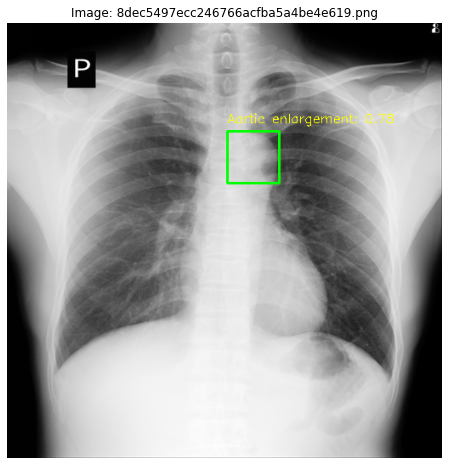

Toa do: 145 232 408 328
Toa do: 250 105 364 206
Toa do: 144 156 415 342


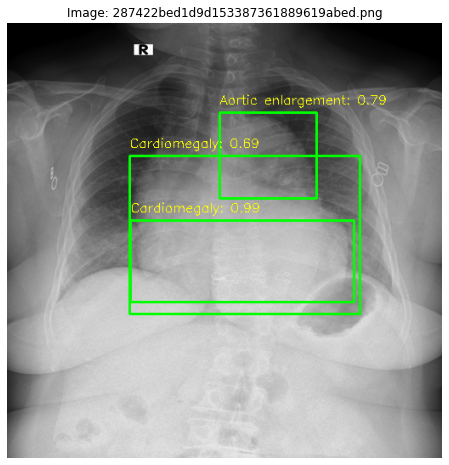

Toa do: 241 169 294 215
Toa do: 177 297 391 371
Toa do: 313 301 330 312


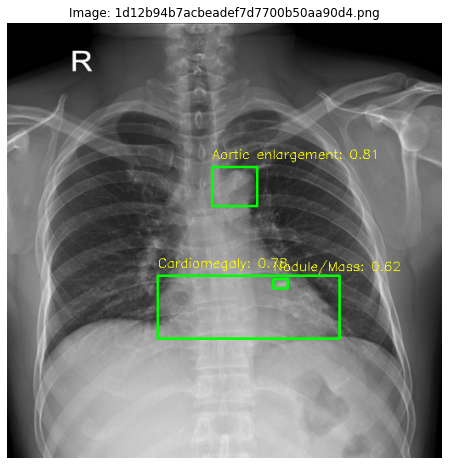

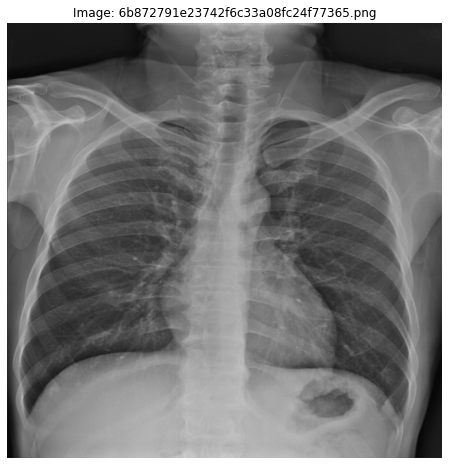

Toa do: 311 149 374 205
Toa do: 254 277 462 331
Toa do: 396 85 444 112


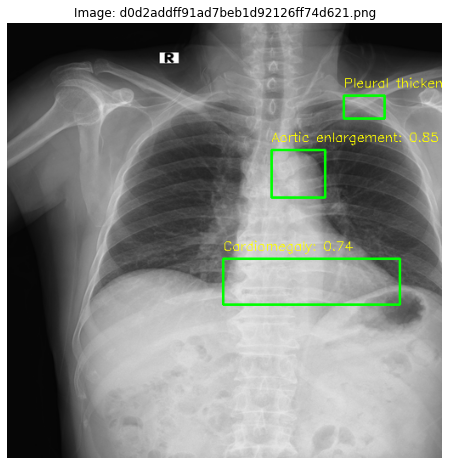

Toa do: 203 307 430 382
Toa do: 294 206 350 254


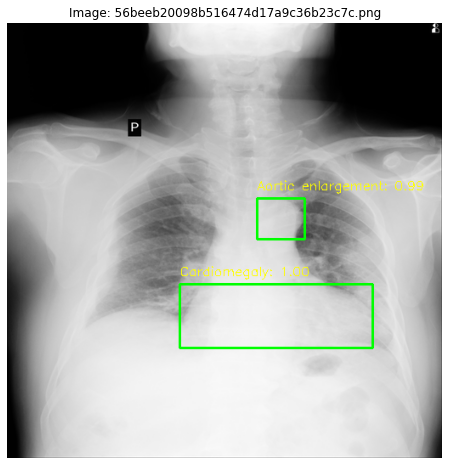

Toa do: 260 97 322 167


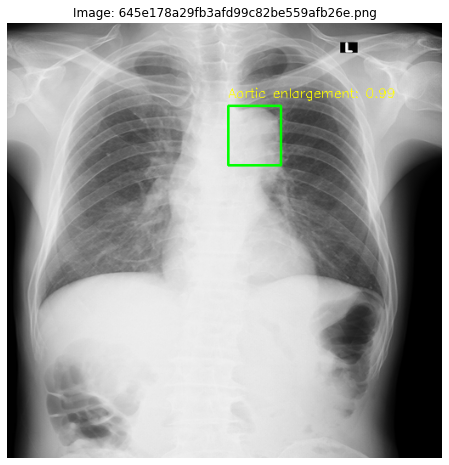

Toa do: 260 158 314 209
Toa do: 181 272 374 330


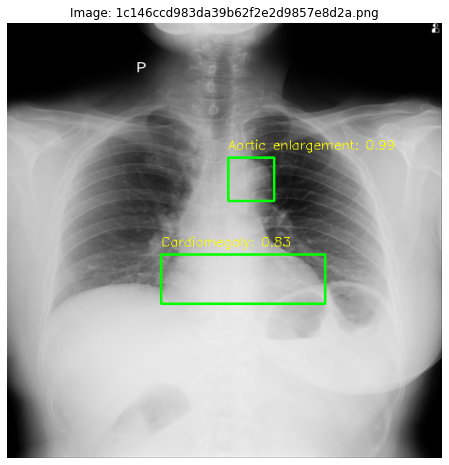

Toa do: 122 156 165 215
Toa do: 132 105 203 124


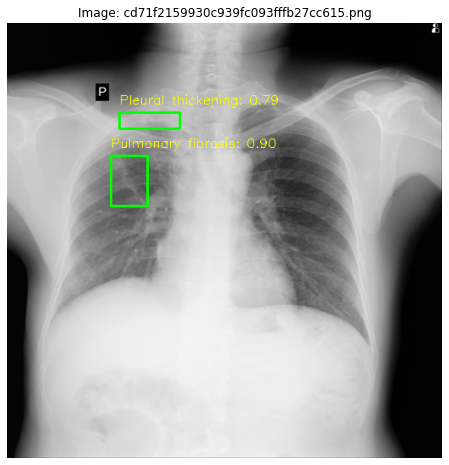

Toa do: 270 117 319 162


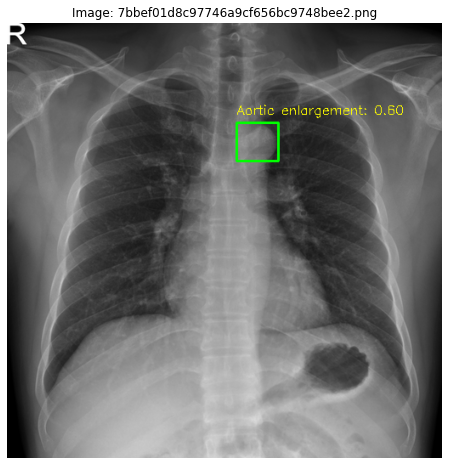

Toa do: 179 236 432 333


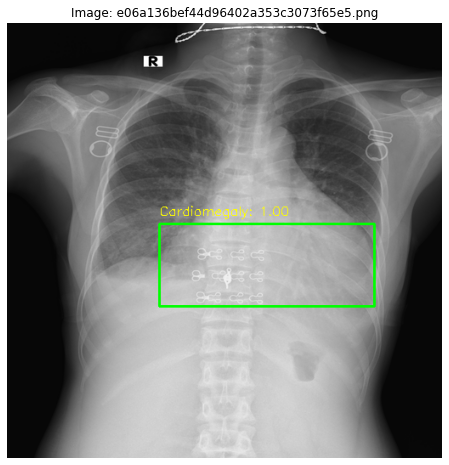

Toa do: 271 147 338 209
Toa do: 212 280 424 352


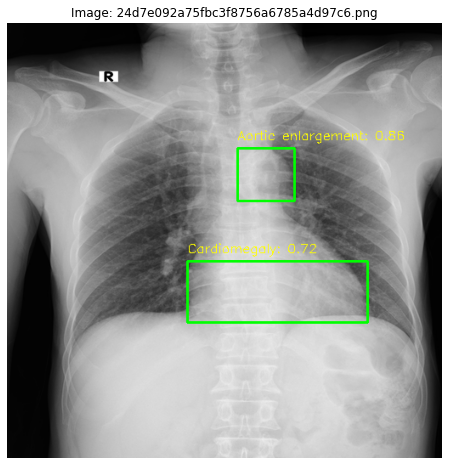

Toa do: 249 105 306 159


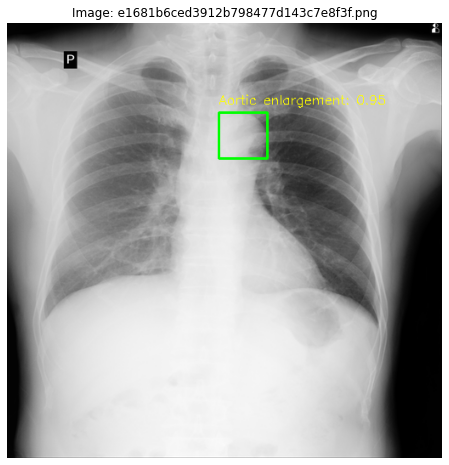

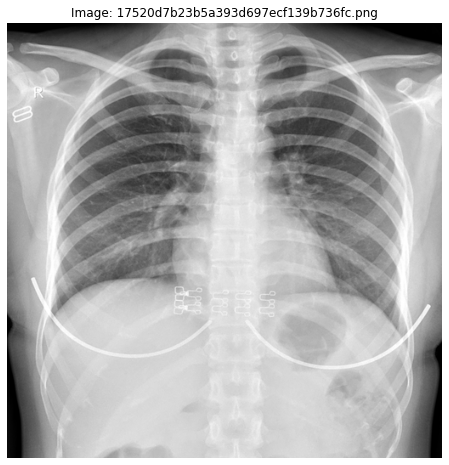

Toa do: 232 132 286 181


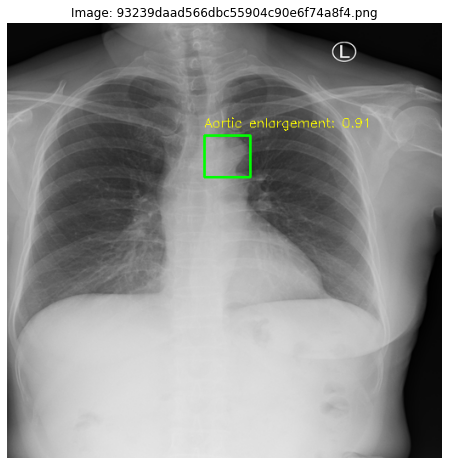

Toa do: 260 173 318 228


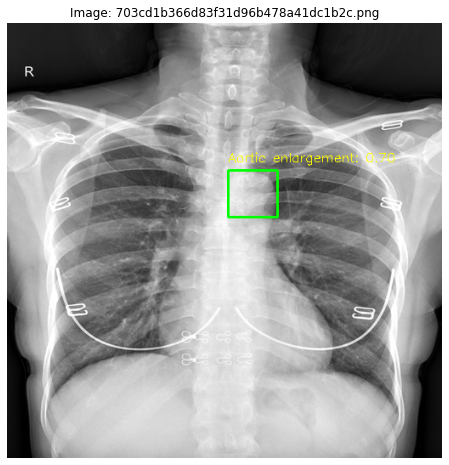

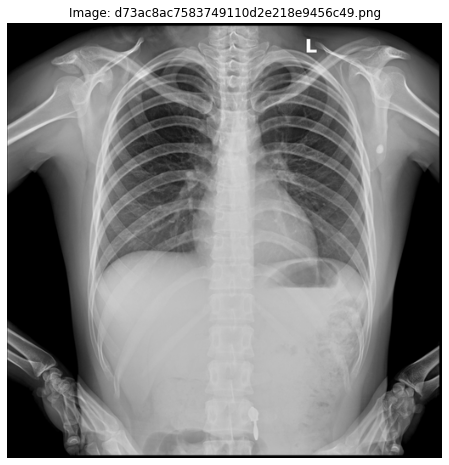

Toa do: 162 283 402 361
Toa do: 293 44 360 62
Toa do: 247 126 308 179


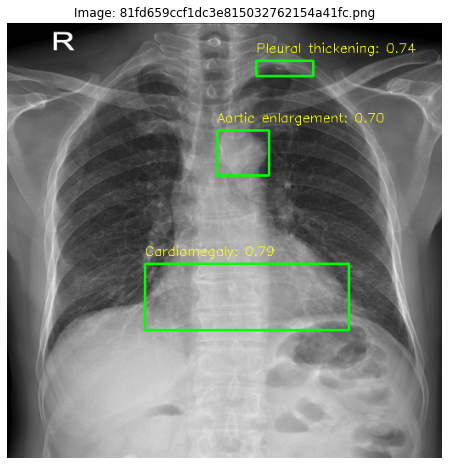

Toa do: 258 137 323 200


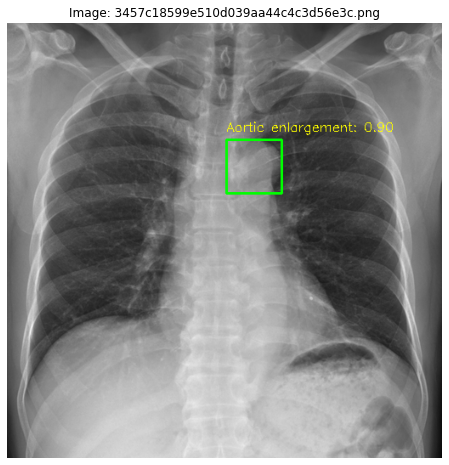

Toa do: 170 227 393 292
Toa do: 259 122 322 178


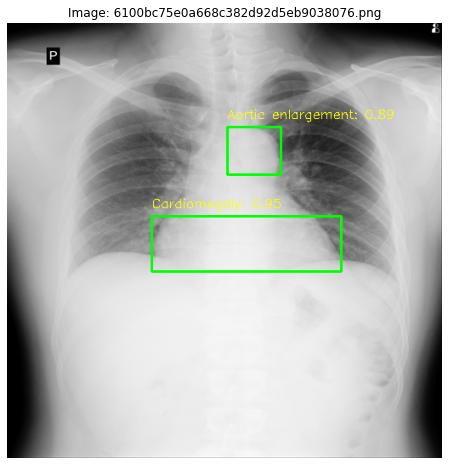

In [ ]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd

def display_predictions(dataset_dicts, predictions):
    """
    Hiển thị hình ảnh từ dataset_dicts với các bounding boxes từ predictions.

    Args:
    - dataset_dicts: Danh sách các từ điển chứa thông tin về ảnh (file_name, annotations,...).
    - predictions: Danh sách dự đoán, mỗi phần tử là (boxes, labels, scores).
    """
    for idx, (data, (labels, scores, boxs)) in enumerate(zip(dataset_dicts, predictions)):
        if idx >= 20:  # Hiển thị tối đa 10 ảnh
            break
        
        # Đọc ảnh từ đường dẫn
        img_path = data["file_name"]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img_id = data["image_id"]
        height, width, channels = img.shape
        h_ratio1 = height / test_meta.loc[test_meta['image_id'] == img_id, 'dim0'].values[0]
        w_ratio1 = width / test_meta.loc[test_meta['image_id'] == img_id, 'dim1'].values[0]
        # print(f"Kích thước ảnh: Width={width}, Height={height}, Channels={channels}")
        # Vẽ bounding boxes lên ảnh
        for label, score, box in zip(labels, scores, boxs):
            if label < 14:
                x1, y1, x2, y2 = [int(coordinate_org * (w_ratio1 if i % 2 == 0 else h_ratio1)) for i, coordinate_org in enumerate(box)]
                print(f"Toa do: {x1} {y1} {x2} {y2}")
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(
                    img, f"{thing_classes[label]}: {score:.2f}", 
                    (x1, max(y1 - 10, 0)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (255, 255, 0), 1
                )
        
        # Hiển thị ảnh
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Image: {img_path.split('/')[-1]}")
        plt.show()

# Đọc file submission.csv
submission_det = pd.read_csv(outdir / "submission.csv")  # Thay bằng đường dẫn đúng

# Chuyển đổi PredictionString thành bounding boxes, labels và scores
def parse_prediction_string(pred_str):
    """
    Phân tích PredictionString từ submission.csv.

    Args:
    - pred_str: Chuỗi chứa thông tin các bounding boxes.

    Returns:
    - boxes: Danh sách các bounding boxes [[x1, y1, x2, y2], ...].
    - labels: Danh sách các nhãn (labels).
    - scores: Danh sách các điểm tin cậy (confidence scores).
    """
    if pd.isna(pred_str):
        return [], [], []
    
    items = list(map(float, pred_str.split()))
    boxes, labels, scores = [], [], []
    for i in range(0, len(items), 6):
        label, score, x1, y1, x2, y2 = items[i:i+6]
        boxes.append([x1, y1, x2, y2])
        scores.append(score)
        labels.append(int(label))
    
    return labels, scores, boxes

# Tạo danh sách dự đoán từ submission.csv
predictions = [
    parse_prediction_string(row.PredictionString) 
    for _, row in submission_det.iterrows()
]

# Hiển thị ảnh với các bounding box
# dataset_dicts cần được định nghĩa trước (chứa thông tin về file_name)
display_predictions(dataset_dicts, predictions)


In [ ]:
submission_det["PredictionString"].head(3)

0                0 0.775484561920166 1010 603 1248 893
1    3 0.9862767457962036 666 1289 1865 1820 0 0.78...
2    0 0.8117097616195679 1173 896 1433 1138 3 0.78...
Name: PredictionString, dtype: object

In [ ]:
# for i, row in submission_det.iterrows():
#     print(f"Image ID: {row['image_id']}")
#     print(f"PredictionString: {row['PredictionString']}")
#     boxes, labels, scores = parse_prediction_string(row['PredictionString'])
#     print(f"Boxes: {boxes}, Scores: {scores}, Labels: {labels}")
#     # Kiểm tra xem box có hợp lý không
#     for box in boxes:
#         x1, y1, x2, y2 = box
#         assert 0 <= x1 < x2, f"Invalid box: {box}"
#         assert 0 <= y1 < y2, f"Invalid box: {box}"

**Predict on 1 image**

In [ ]:
print(type(dataset_dicts[:3]))

<class 'list'>


In [ ]:
image_path = "/kaggle/input/vinbigdata/test/8dec5497ecc246766acfba5a4be4e619.png"
image_path2 = "/kaggle/input/vinbigdata/test/287422bed1d9d153387361889619abed.png"
image_path3 = "/kaggle/input/vinbigdata/test/1d12b94b7acbeadef7d7700b50aa90d4.png"

image = cv2.imread(image_path)
image2 = cv2.imread(image_path2)
image3 = cv2.imread(image_path3)

# Use predict_batch for a single image (wrap the image in a list)
print(dataset_dicts[:3])
single_prediction = predict_batch(predictor, [image,image2,image3])
print(single_prediction)
# Extract the prediction for the single image
prediction = single_prediction[0]
print("prediction: ", prediction)

# # Visualization (optional)
# v = Visualizer(
#     image[:, :, ::-1],
#     metadata=MetadataCatalog.get("vinbigdata_test"),
#     scale=0.5,
#     instance_mode=ColorMode.IMAGE_BW
# )
# output = v.draw_instance_predictions(prediction["instances"].to("cpu"))
# plt.imshow(output.get_image()[:, :, ::-1])
# plt.axis("off")  # Turn off axis
# plt.show()  # Display the image
# # cv2.imwrite("output_image.jpg", output.get_image()[:, :, ::-1])  # Save result

[{'file_name': '/kaggle/input/vinbigdata/test/8dec5497ecc246766acfba5a4be4e619.png', 'image_id': '8dec5497ecc246766acfba5a4be4e619', 'height': 512, 'width': 512}, {'file_name': '/kaggle/input/vinbigdata/test/287422bed1d9d153387361889619abed.png', 'image_id': '287422bed1d9d153387361889619abed', 'height': 512, 'width': 512}, {'file_name': '/kaggle/input/vinbigdata/test/1d12b94b7acbeadef7d7700b50aa90d4.png', 'image_id': '1d12b94b7acbeadef7d7700b50aa90d4', 'height': 512, 'width': 512}]
[{'instances': Instances(num_instances=1, image_height=512, image_width=512, fields=[pred_boxes: Boxes(tensor([[259.5901, 127.2220, 320.6352, 188.2842]], device='cuda:0')), scores: tensor([0.7755], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}, {'instances': Instances(num_instances=3, image_height=512, image_width=512, fields=[pred_boxes: Boxes(tensor([[146.1597, 232.7401, 408.9134, 328.5916],
        [250.2187, 105.4411, 364.7564, 206.2025],
        [144.3994, 156.1698, 415.7886, 342.8988]

In [ ]:
dt_temp = dataset_dicts[:3]
print('list image: ', dt_temp)
count = 0
for i in tqdm(range(ceil(len(dt_temp) / batch_size))):
    inds1 = list(range(batch_size * i, min(batch_size * (i + 1), len(dt_temp))))
    dataset_dicts_batch1 = [dt_temp[i] for i in inds1]
    im_list1 = [cv2.imread(d["file_name"]) for d in dataset_dicts_batch1]
    # print('type: ', im_list1)
    outputs_list = predict_batch(predictor, im_list1)
    count = count + 1
    print('output listz: ', outputs_list)
print('count: ', count)

  0%|          | 0/1 [00:00<?, ?it/s]

list image:  [{'file_name': '/kaggle/input/vinbigdata/test/8dec5497ecc246766acfba5a4be4e619.png', 'image_id': '8dec5497ecc246766acfba5a4be4e619', 'height': 512, 'width': 512}, {'file_name': '/kaggle/input/vinbigdata/test/287422bed1d9d153387361889619abed.png', 'image_id': '287422bed1d9d153387361889619abed', 'height': 512, 'width': 512}, {'file_name': '/kaggle/input/vinbigdata/test/1d12b94b7acbeadef7d7700b50aa90d4.png', 'image_id': '1d12b94b7acbeadef7d7700b50aa90d4', 'height': 512, 'width': 512}]


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

output listz:  [{'instances': Instances(num_instances=1, image_height=512, image_width=512, fields=[pred_boxes: Boxes(tensor([[259.5901, 127.2220, 320.6352, 188.2842]], device='cuda:0')), scores: tensor([0.7755], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}, {'instances': Instances(num_instances=3, image_height=512, image_width=512, fields=[pred_boxes: Boxes(tensor([[146.1597, 232.7401, 408.9134, 328.5916],
        [250.2187, 105.4411, 364.7564, 206.2025],
        [144.3994, 156.1698, 415.7886, 342.8988]], device='cuda:0')), scores: tensor([0.9863, 0.7886, 0.6927], device='cuda:0'), pred_classes: tensor([3, 0, 3], device='cuda:0')])}, {'instances': Instances(num_instances=3, image_height=512, image_width=512, fields=[pred_boxes: Boxes(tensor([[241.0500, 169.5419, 294.4226, 215.4717],
        [177.2302, 297.3117, 391.4166, 371.8921],
        [314.0260, 301.1113, 330.2263, 312.8058]], device='cuda:0')), scores: tensor([0.8117, 0.7831, 0.6194], device='cuda:0'), pred_cl

In [ ]:
dt_temp = dataset_dicts[:3]
print('list image: ', dt_temp)
# inds1 = list(range(batch_size * i, min(batch_size * (i + 1), len(dt_temp))))
# dataset_dicts_batch1 = [dt_temp[i] for i in inds1]
im_list1 = [cv2.imread(d["file_name"]) for d in dt_temp]
outputs_list = predict_batch(predictor, im_list1)
print('output listz: ', outputs_list)

list image:  [{'file_name': '/kaggle/input/vinbigdata/test/8dec5497ecc246766acfba5a4be4e619.png', 'image_id': '8dec5497ecc246766acfba5a4be4e619', 'height': 512, 'width': 512}, {'file_name': '/kaggle/input/vinbigdata/test/287422bed1d9d153387361889619abed.png', 'image_id': '287422bed1d9d153387361889619abed', 'height': 512, 'width': 512}, {'file_name': '/kaggle/input/vinbigdata/test/1d12b94b7acbeadef7d7700b50aa90d4.png', 'image_id': '1d12b94b7acbeadef7d7700b50aa90d4', 'height': 512, 'width': 512}]
output listz:  [{'instances': Instances(num_instances=1, image_height=512, image_width=512, fields=[pred_boxes: Boxes(tensor([[259.5901, 127.2220, 320.6352, 188.2842]], device='cuda:0')), scores: tensor([0.7755], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}, {'instances': Instances(num_instances=3, image_height=512, image_width=512, fields=[pred_boxes: Boxes(tensor([[146.1597, 232.7401, 408.9134, 328.5916],
        [250.2187, 105.4411, 364.7564, 206.2025],
        [144.3994, 1

<a id="2class"></a>
# Apply 2 class filter

I moved this section to [📸VinBigData 2-class classifier complete pipeline](https://www.kaggle.com/corochann/vinbigdata-2-class-classifier-complete-pipeline).<br/>
Please refer the kernel, **it improves LB score significantly from 0.141 -> 0.221**.

**Discussion: How to improve more?**

I'm now thinking that it's better to include normal images for training to learn where there is **no** abnormality.<br/>
Also, I think it's nice to try **including "No finding" class during detection training** (by adding virtual "No finding" boxes, or by adding global classifier together with the detection).


That's all!
Object deteaction is rather complicated task among deep learning tasks, but it's easy to train SoTA models & predict using `detectron2`!!!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated 😁<br>Thanks!</h3>

<a id="ref"></a>
# Other kernels

[📸VinBigData detectron2 train](https://www.kaggle.com/corochann/vinbigdata-detectron2-train) kernel explains how to run object detection training, using `detectron2` library.

[📸VinBigData 2-class classifier complete pipeline](https://www.kaggle.com/corochann/vinbigdata-2-class-classifier-complete-pipeline) kernel explains how to train 2 class classifier model for the prediction and submisssion for this competition.

In [ ]:
!python --version

Python 3.7.6
